# Webscrapper to Obtain Financial Data from Yahoo Finance

In [78]:
# !pip install yfinance

## Import Modules

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import os
from datetime import datetime, timedelta
import pytz

## Example Stock data - Microsoft (MSFT)

In [80]:
msft = yf.Ticker("MSFT")

# get all stock info
info = msft.info

# get historical market data
hist = msft.history(period="10y")


# # show financials:
# msft.calendar
# msft.sec_filings
# # - income statement
# msft.income_stmt
# msft.quarterly_income_stmt
# # - balance sheet
# msft.balance_sheet
# msft.quarterly_balance_sheet
# # - cash flow statement
# msft.cashflow
# msft.quarterly_cashflow
# # see `Ticker.get_income_stmt()` for more options


# View all available metrics for this stock
for key, value in msft.info.items():
    print(f"{key}: {value}")

address1: One Microsoft Way
city: Redmond
state: WA
zip: 98052-6399
country: United States
phone: 425 882 8080
website: https://www.microsoft.com
industry: Software - Infrastructure
industryKey: software-infrastructure
industryDisp: Software - Infrastructure
sector: Technology
sectorKey: technology
sectorDisp: Technology
longBusinessSummary: Microsoft Corporation develops and supports software, services, devices and solutions worldwide. The Productivity and Business Processes segment offers office, exchange, SharePoint, Microsoft Teams, office 365 Security and Compliance, Microsoft viva, and Microsoft 365 copilot; and office consumer services, such as Microsoft 365 consumer subscriptions, Office licensed on-premises, and other office services. This segment also provides LinkedIn; and dynamics business solutions, including Dynamics 365, a set of intelligent, cloud-based applications across ERP, CRM, power apps, and power automate; and on-premises ERP and CRM applications. The Intelligen

In [81]:
# History data keys 
hist.keys()

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

<Axes: xlabel='Date'>

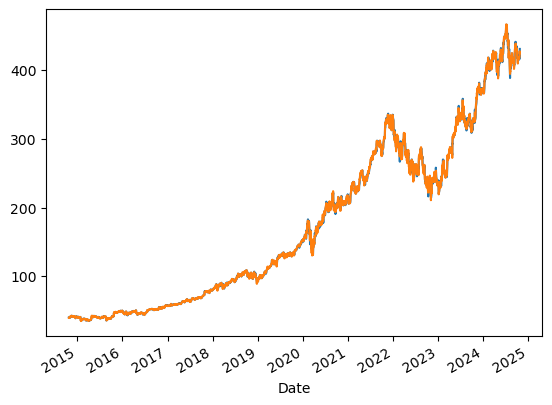

In [82]:
hist['Open'].plot()
hist['Close'].plot()
# hist['Dividends'].plot()
# hist['Stock Splits'].plot()

## Get Historical Stock Data

In [83]:
class StockDataScraper:
    def __init__(self, stock, path_to_data="stock_data"):
        # Strip any leading/trailing spaces from the stock symbol
        self.stock = stock.strip()
        self.path_to_data = path_to_data
        self.ticker = yf.Ticker(self.stock)
        
        # Create the stock-specific directory inside the base directory
        self.stock_folder = os.path.join(self.path_to_data, self.stock)
        if not os.path.exists(self.stock_folder):
            os.makedirs(self.stock_folder)
    
    def get_stock_info(self):
        """Fetches the company information and saves it to stock_info.csv."""
        try:
            stock_info = pd.DataFrame.from_dict(self.ticker.info, orient='index').T
            stock_info_file = os.path.join(self.stock_folder, 'stock_info.csv')
            stock_info.to_csv(stock_info_file, index=False)
            print(f"Stock info saved to {stock_info_file}")
        except Exception as e:
            print(f"Error retrieving stock info for {self.stock}: {e}")
    
    def get_historical_data(self):
        """Fetches the historical stock data for the past 20 years (daily interval) and saves it to stock_price.csv."""
        try:
            end_date = pd.Timestamp("2024-09-30")
            start_date = (datetime.today() - timedelta(days=20*365)).strftime('%Y-%m-%d')
            hist_data = self.ticker.history(start=start_date, end=end_date, interval='1d')
            stock_price_file = os.path.join(self.stock_folder, 'stock_price.csv')
            hist_data.to_csv(stock_price_file)
            print(f"Historical data saved to {stock_price_file}")
        except Exception as e:
            print(f"Error retrieving historical data for {self.stock}: {e}")
    
    def get_quarterly_data(self, years=20):
        """
        Fetches quarterly income statement, balance sheet, and cash flow for the past 'years' years (10 or 20), 
        and saves them to stock_quarter.csv.
        """
        try:
            # Fetching the quarterly financials
            income_stmt = self.ticker.quarterly_income_stmt.T
            balance_sheet = self.ticker.quarterly_balance_sheet.T
            cashflow = self.ticker.quarterly_cashflow.T

            # Convert the column headers (dates) to pandas Timestamps for comparison
            income_stmt.columns = pd.to_datetime(income_stmt.columns)
            balance_sheet.columns = pd.to_datetime(balance_sheet.columns)
            cashflow.columns = pd.to_datetime(cashflow.columns)

            # Filter to the past `years` if necessary
            if years:
                end_date = pd.Timestamp("2024-09-30")
                start_date = end_date - timedelta(days=years*365)  # Calculate start date based on requested years
                
                # Filter the DataFrames by the date range
                income_stmt = income_stmt.loc[:, income_stmt.columns >= pd.Timestamp(start_date)]
                balance_sheet = balance_sheet.loc[:, balance_sheet.columns >= pd.Timestamp(start_date)]
                cashflow = cashflow.loc[:, cashflow.columns >= pd.Timestamp(start_date)]

            # Store all data into a dictionary to export as a CSV
            combined_quarterly_data = {
                'Quarterly Income Statement': income_stmt,
                'Quarterly Balance Sheet': balance_sheet,
                'Quarterly Cash Flow': cashflow
            }

            # File path for the CSV
            stock_quarter_file = os.path.join(self.stock_folder, 'stock_quarter.csv')

            # Writing to CSV
            with open(stock_quarter_file, 'w') as f:
                for key, df in combined_quarterly_data.items():
                    f.write(f"\n\n{key}\n")  # Section title
                    if not df.empty:
                        df.to_csv(f, index=True)  # Export each DataFrame to the CSV

            print(f"Quarterly financials for {self.stock} saved to {stock_quarter_file}")

        except Exception as e:
            print(f"Error retrieving quarterly financials for {self.stock}: {e}")


    def get_stock_news(self):
        """Fetches financial news for the last 20 years and saves to stock_news.csv."""
        try:
            news = self.ticker.news
            news_df = pd.DataFrame(news)
            
            if not news_df.empty:
                news_df = news_df[['title', 'publisher', 'link', 'providerPublishTime']]
                news_df['providerPublishTime'] = pd.to_datetime(news_df['providerPublishTime'], unit='s')
                start_date = (datetime.today() - timedelta(days=20*365)).strftime('%Y-%m-%d')
                news_df = news_df[news_df['providerPublishTime'] >= pd.Timestamp(start_date)]
            
            stock_news_file = os.path.join(self.stock_folder, 'stock_news.csv')
            news_df.to_csv(stock_news_file, index=False)
            print(f"News data saved to {stock_news_file}")
        except Exception as e:
            print(f"Error retrieving news for {self.stock}: {e}")
    
    
    def scrape_all_data(self):
        """Scrapes all the required data and saves them to CSV files."""
        print(f"Stock : {stock}")
        self.get_stock_info()
        self.get_historical_data()
        # self.get_quarterly_data()
        self.get_stock_news()
        print()


In [84]:
# Define the base directory where the stock data will be stored
path_to_data = "stock_data"

# List of stocks to scrape
stocks = ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'META', 'GOOGL', 'TSM', 'AVGO', 'LLY', 
              'JPM', 'TSLA', 'XOM', 'UNH', 'V', 'MA', 'HD', 'PG', 'JNJ', 'COST', 'WMT', 
              'ABBV', 'NFLX', 'BAC', 'KO', 'CVX', 'AMD', 'PEP', 'ACN', 'CSCO', 'TMO', 
              'MCD', 'ADBE', 'WFC', 'IBM', 'GE', 'ABT', 'QCOM', 'VZ', 'DIS', 'NEE', 
              'DHR', 'UBER', 'INTU', 'SPGI', 'ISRG', 'PFE', 'RTX', 'GS', 'CMSA', 'LOW', 'BRK-B']
# stocks = ['MSFT']

len_stocks = len(stocks)
print(len_stocks)

# Loop through the list of stocks and scrape data using the StockDataScraper class
for stock in stocks:
    scraper = StockDataScraper(stock)
    scraper.scrape_all_data()

51
Stock : AAPL
Stock info saved to stock_data\AAPL\stock_info.csv
Historical data saved to stock_data\AAPL\stock_price.csv
News data saved to stock_data\AAPL\stock_news.csv

Stock : NVDA
Stock info saved to stock_data\NVDA\stock_info.csv
Historical data saved to stock_data\NVDA\stock_price.csv
News data saved to stock_data\NVDA\stock_news.csv

Stock : MSFT
Stock info saved to stock_data\MSFT\stock_info.csv
Historical data saved to stock_data\MSFT\stock_price.csv
News data saved to stock_data\MSFT\stock_news.csv

Stock : AMZN
Stock info saved to stock_data\AMZN\stock_info.csv
Historical data saved to stock_data\AMZN\stock_price.csv
News data saved to stock_data\AMZN\stock_news.csv

Stock : META
Stock info saved to stock_data\META\stock_info.csv
Historical data saved to stock_data\META\stock_price.csv
News data saved to stock_data\META\stock_news.csv

Stock : GOOGL
Stock info saved to stock_data\GOOGL\stock_info.csv
Historical data saved to stock_data\GOOGL\stock_price.csv
News data sav